# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**Taylor Galdi

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2024-12-13 11:37:14.464540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

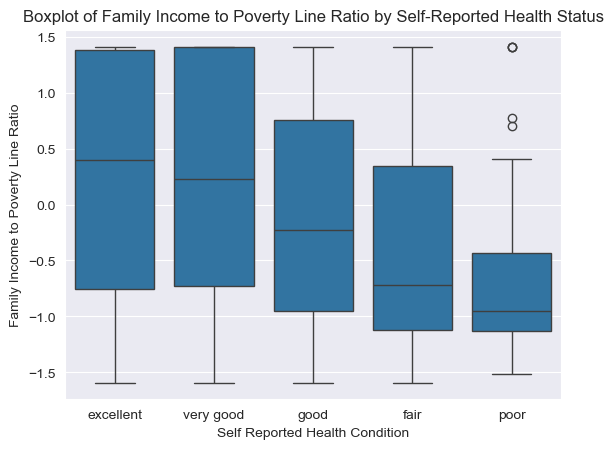

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

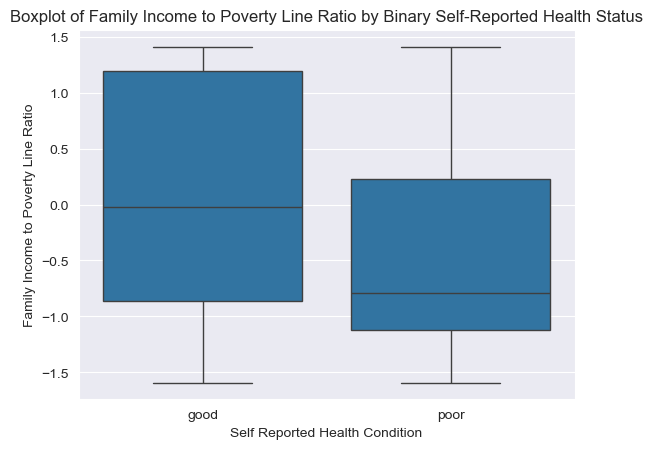

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

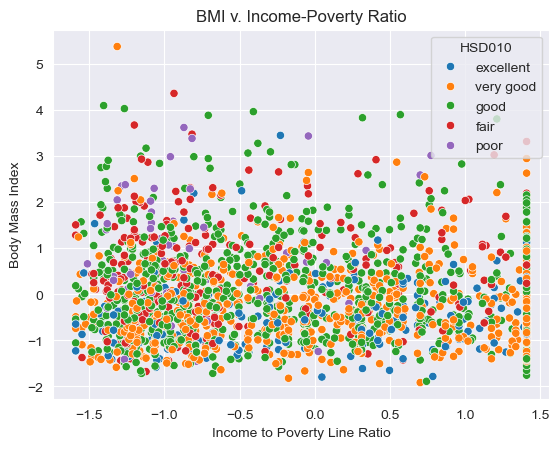

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanestarget = nhanes_scaled

In [7]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)
print(nhanes_scaled.head())

       DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
SEQN                                                                       
73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

       DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ033    OHQ770    OHQ845  \
SEQN                                 ...                                 
73568 -0.057306  0.128246 -0.189513  ... -0.680203  0.383802 -0.646584   
73576 -0.057306  0.128246  0.080373  ... -0.680203  0.383802 -1.539259   
73579 -0.057306  0.128246 -0.189513  ... -0.680203  0.383802 -1.539259   
73581 -0.057306  0.128246  0.080373  ... -0.680203  0.383802 -0.646584   
73584 -0.057306  0.1282

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [8]:
# scale data (without scaling the index)
# ----------
scaler = StandardScaler()
X = scaler.fit_transform(nhanes_scaled)

# Convert the scaled data back into a DataFrame with the original column names and index
X = pd.DataFrame(X, columns=nhanes_scaled.columns, index=nhanes_scaled.index)

# Verify the result
print(X.head())

       DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
SEQN                                                                       
73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

       DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ033    OHQ770    OHQ845  \
SEQN                                 ...                                 
73568 -0.057306  0.128246 -0.189513  ... -0.680203  0.383802 -0.646584   
73576 -0.057306  0.128246  0.080373  ... -0.680203  0.383802 -1.539259   
73579 -0.057306  0.128246 -0.189513  ... -0.680203  0.383802 -1.539259   
73581 -0.057306  0.128246  0.080373  ... -0.680203  0.383802 -0.646584   
73584 -0.057306  0.1282

In [9]:
# apply PCA
# ----------
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes = pca_all.fit_transform(X)

### Scree Plot(s) of Explained Variance

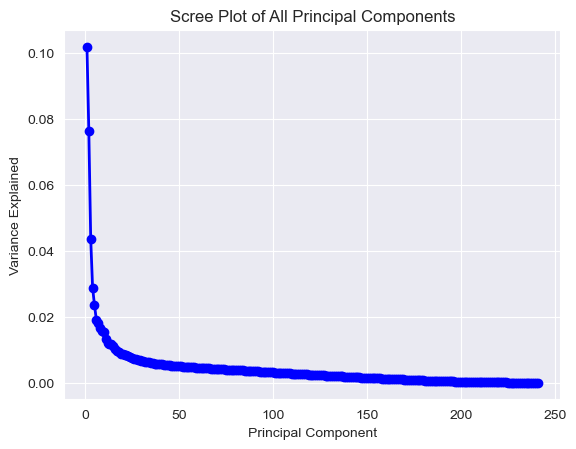

In [10]:
# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot of All Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Obviously, this is far too many components. There is an elbow here somewhere between 0-50, so let's just plot the first 20 components to see if we can see where there is a reasonable trade off between number of components and amount of variation explained. 

In [11]:
# Fit PCA model for less components 
pca = PCA(n_components=20)
pca.fit(X)

PCA(n_components=20)

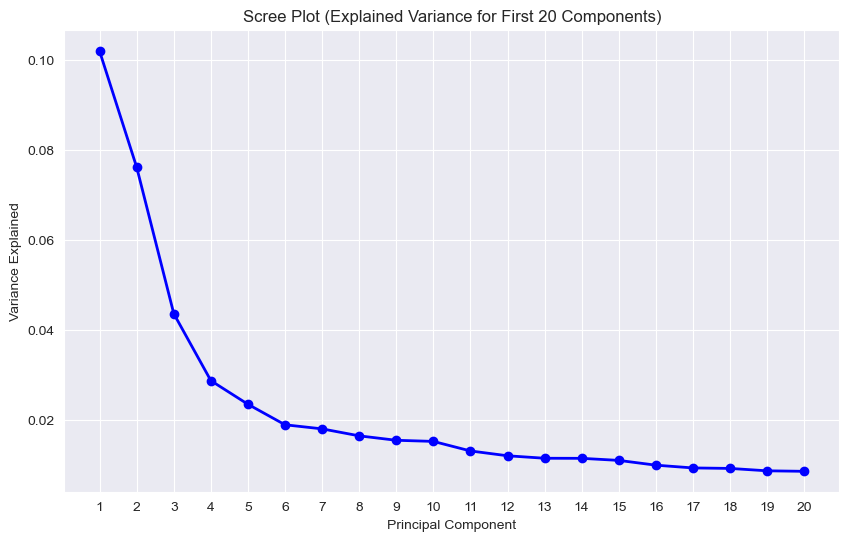

In [12]:
# PC values are the principal component indices (1, 2, 3,...)
PC_values = np.arange(pca.n_components_) + 1

# Create scree plot
plt.figure(figsize=(10, 6))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')

# Title and labels
plt.title('Scree Plot (Explained Variance for First 20 Components)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(PC_values)
plt.grid(True)

### Barplot of Components

/var/folders/51/tvqz_23j083bt8bcsjfhnyk40000gn/T/ipykernel_39622/3564382604.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(range(1, len(explained_variance_ratio) + 1)),


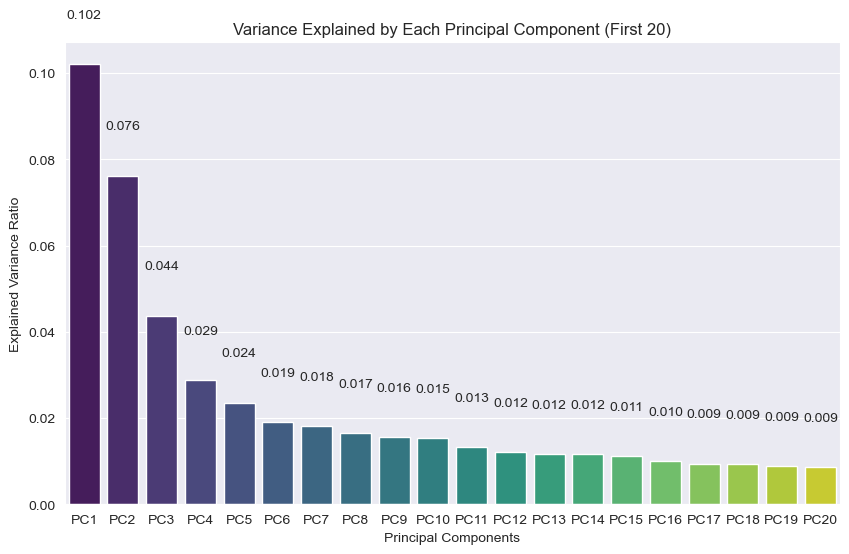

In [13]:
# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a bar plot to show the variance explained by each component
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(range(1, len(explained_variance_ratio) + 1)), 
                 y=explained_variance_ratio, 
                 palette='viridis')

# Add annotations for each bar with the value of explained variance
for i, v in enumerate(explained_variance_ratio):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# Title and labels
plt.title('Variance Explained by Each Principal Component (First 20)')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(ticks=range(len(explained_variance_ratio)), labels=[f'PC{i+1}' for i in range(len(explained_variance_ratio))])
plt.grid(True, axis='y')

# Show the plot
plt.show()

### How many components will you use to fit a supervised learning model?

Based on what we are seeing here and also in the scree plot, I am going to choose 5 components. Because our next step is to apply PCA for only 2 components, I will apply the PCA with 5 components after the following section, before the clustering.

### 2D Scatterplot of the first two components

In [14]:
# apply PCA
# ----------
pca2 = PCA(n_components=2)
pca2_result = pca2.fit_transform(X)

In [15]:
# convert into a dataframe and re-assign SQN as index
# ----------
pca2_df = pd.DataFrame(data=pca2_result, 
                       columns=['principal component 1', 'principal component 2'],
                       index=nhanes_scaled.index)

# Now pca2_df should have the SEQN (index) column
print(pca2_df.head())

       principal component 1  principal component 2
SEQN                                               
73568               9.527811              -0.816216
73576              -5.838339              -3.692558
73579              -0.719454              -2.573202
73581               3.533627              -2.576976
73584              -6.872094              -4.194242


In [16]:
#Now we have to do the same for our target 
SQNnhanestarget = nhanestarget.reset_index()

In [17]:
# Merge the PCA results with the target labels to align the data
merged_df = pca2_df.merge(SQNnhanestarget[['SEQN', 'HSD010','HSD010_binary']], on='SEQN', how='inner')

# Check the merged DataFrame
print(merged_df.head())

    SEQN  principal component 1  principal component 2     HSD010  \
0  73568               9.527811              -0.816216  excellent   
1  73576              -5.838339              -3.692558  excellent   
2  73579              -0.719454              -2.573202  very good   
3  73581               3.533627              -2.576976  very good   
4  73584              -6.872094              -4.194242       good   

  HSD010_binary  
0          good  
1          good  
2          good  
3          good  
4          good  


In [18]:
#Check the original dataframe to make sure that the SEQN aligns with the target 
print(nhanestarget.head())

       DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
SEQN                                                                       
73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

       DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ845   PAAQUEX    SMQ860  \
SEQN                                 ...                                 
73568 -0.057306  0.128246 -0.189513  ... -0.646584 -0.484200  1.125008   
73576 -0.057306  0.128246  0.080373  ... -1.539259 -0.484200  1.125008   
73579 -0.057306  0.128246 -0.189513  ... -1.539259  2.065262 -0.888883   
73581 -0.057306  0.128246  0.080373  ... -0.646584 -0.484200  1.125008   
73584 -0.057306  0.1282

Plotting excellent: 239 points
Plotting very good: 672 points
Plotting good: 821 points
Plotting fair: 273 points
Plotting poor: 59 points


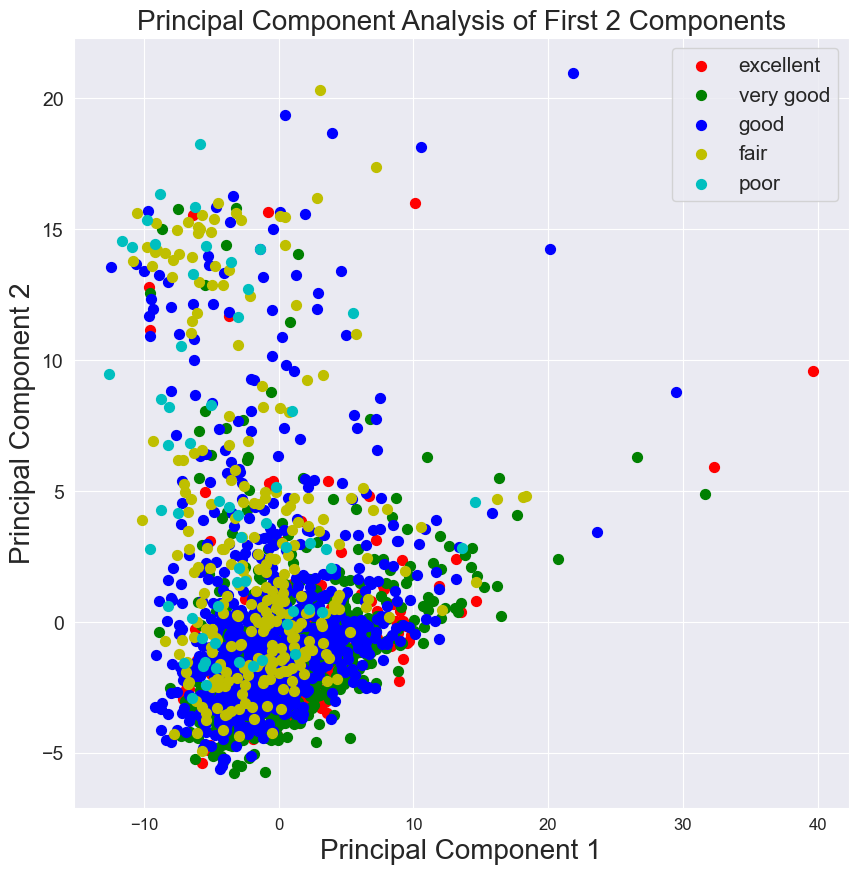

In [19]:
# Update the targets list to include all categories in the HDS10
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['r', 'g', 'b', 'y', 'c']

# Plotting
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Principal Component Analysis of First 2 Components", fontsize=20)

# Loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    # Use the merged DataFrame to filter for the target
    indicesToKeep = merged_df['HSD010'] == target
    print(f"Plotting {target}: {sum(indicesToKeep)} points") 
    if sum(indicesToKeep) > 0:
        # Plot the points for the current category (target)
        plt.scatter(merged_df.loc[indicesToKeep, 'principal component 1'],
                    merged_df.loc[indicesToKeep, 'principal component 2'], 
                    c=color, label=target, s=50)

# Add a legend
plt.legend(targets, prop={'size': 15})
plt.show()

Okay, that's a little messy, let's look at the binary version of the target.

Plotting good: 1732 points
Plotting poor: 332 points


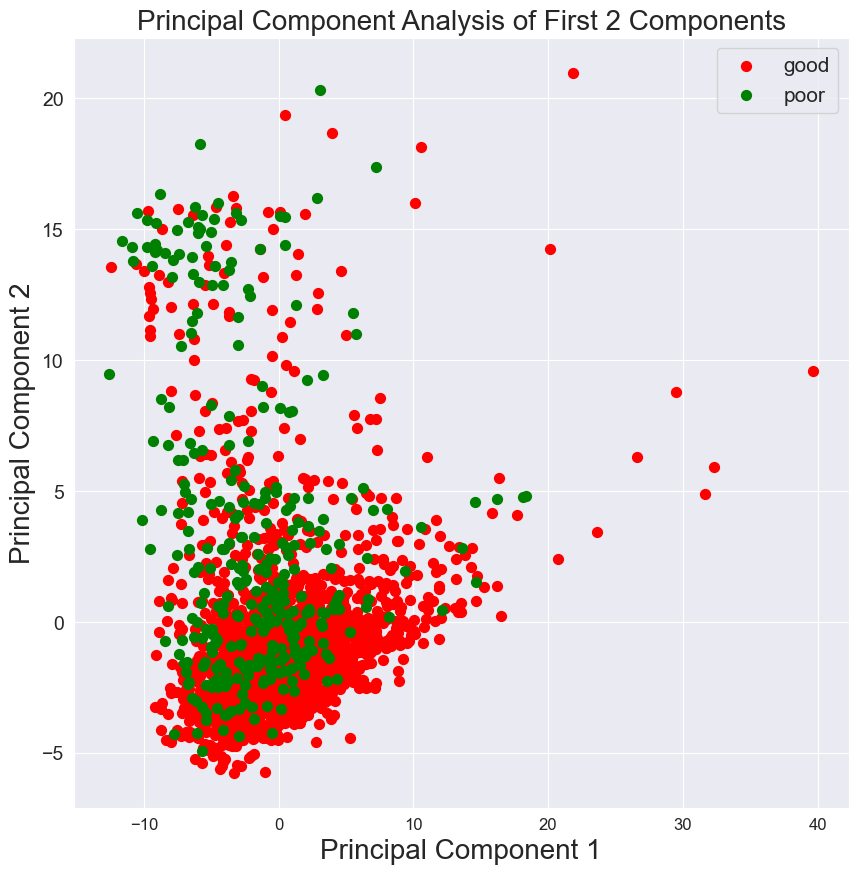

In [20]:
#Update the targets list to include all categories in the HDS10_binary
targets = [ 'good', 'poor']
colors = ['r', 'g']

# Plotting
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Principal Component Analysis of First 2 Components", fontsize=20)

# Loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    # Use the merged DataFrame to filter for the target
    indicesToKeep = merged_df['HSD010_binary'] == target
    print(f"Plotting {target}: {sum(indicesToKeep)} points")  
    if sum(indicesToKeep) > 0:
        # Plot the points for the current category (target)
        plt.scatter(merged_df.loc[indicesToKeep, 'principal component 1'],
                    merged_df.loc[indicesToKeep, 'principal component 2'], 
                    c=color, label=target, s=50)

# Add a legend
plt.legend(targets, prop={'size': 15})
plt.show()

So, unlike the notebook we did in class, this mapping (though now better because the target's binarized), is not really telling us much. Obviously we are doing this as a requirement for the project, but otherwise, I would take this portion out and just stick with my 5 components (which I'm doing directly below).

## PCA With Chosen Number of Components (5)

In [21]:
# apply PCA
# ----------
pca5 = PCA(n_components=5)
pca5_result = pca5.fit_transform(X)

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [22]:
## Your Answer Here

### Cluster nhanes

In [23]:
# load libraries 
# ----------
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn import metrics

# settings
%matplotlib inline

In [24]:
#Scale the data for this section
scaler = StandardScaler()
kmeansscale= scaler.fit_transform(nhanes_scaled)
kmeansscale=pd.DataFrame(kmeansscale, columns=nhanes_scaled.columns)

Inertia values:
1 : 485040.0
2 : 456520.723793382
3 : 430162.74183996714
4 : 418161.7907543633
5 : 412132.7762390529
6 : 407214.9650603783
7 : 401453.5496475767
8 : 398272.3905769178
9 : 395300.4218578251


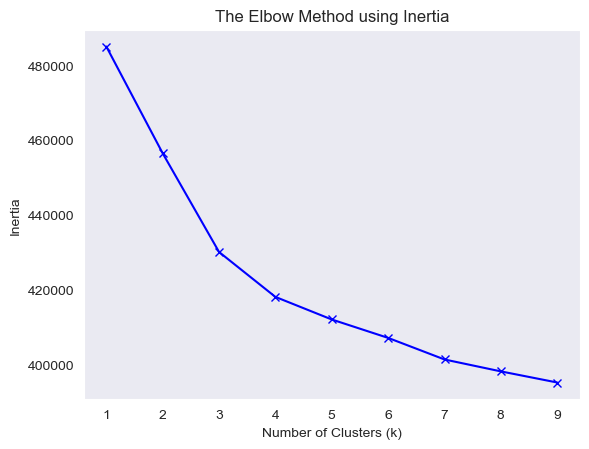

In [25]:
# Initialize lists to store inertia values
inertias = []
mapping = {}
K = range(1, 10)

# Fit K-means for different values of k
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(kmeansscale)
    
    # Get intertia values
    inertias.append(kmeanModel.inertia_)
    
    # Store the mappings for easy access
    mapping[k] = inertias[-1]

print("Inertia values:")
for key, val in mapping.items():
    print(f'{key} : {val}')
# Plotting the graph of k versus Inertia
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid()
plt.show()

We extracted and plotted the inertia values for different k (clusters) in order to choose the ideal number of clusters. Based on this graph, I am going to use three clusters, as that seems like the steepest part of the elbow to me. Even with the intertia values, my understanding is that this is sort of a subjective choice (i.e. there's no predetermined formula) but that the choice for number of clusters has to be defensible in a theoretical sense (though for the purposes of this project I don't necessarily have the domain-specific knowledge of theory to back up this decision of cluster selection).

In [26]:
# set random seed
np.random.seed(10)

In [27]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(kmeansscale)

In [28]:
#Comment out for Kasey
# print the centers 
#print("Centers")
#print(kmeans.cluster_centers_)
#print()

# print labels
#print("Labels")
#print(kmeans.labels_)
#print()

# print coordinates and labels 
#for point, label in zip(kmeansscale, kmeans.labels_):
    #print("Coordinates:", point, "Label:", label)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

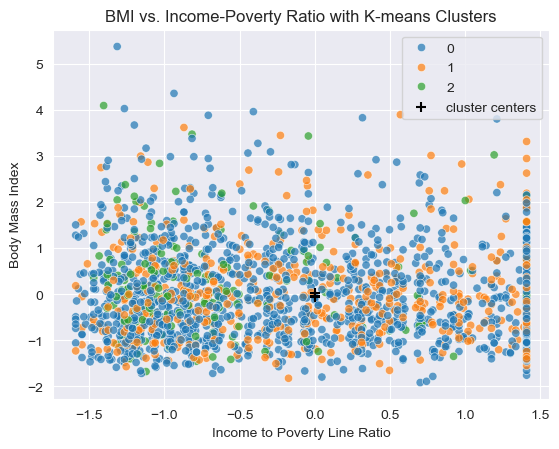

In [29]:
# Store the cluster labels
kmeans_labels = kmeans.labels_

# Recreate the scatter plot with BMI vs Income-to-Poverty Ratio
ax = sns.scatterplot(x="INDFMPIR", y="BMXBMI", 
                     hue=kmeans_labels, 
                     palette="tab10", 
                     data=kmeansscale, 
                     legend="full",
                    alpha=0.7)

# Plot the cluster centers on top of the scatter plot
centers = kmeans.cluster_centers_

# Plotting each cluster center (use a larger size and '+' marker)
ax.scatter(centers[:, 0], centers[:, 1], s=50,  marker='+', c='black', label='cluster centers')

# Set the axis labels and plot title
ax.set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
ax.set_title("BMI vs. Income-Poverty Ratio with K-means Clusters")

# Show the plot with the legend
plt.legend()
plt.show()

So, from what I am seeing here, because the clusters look so messy in this feature space (the cluster centers are close to one another and the clusters are disorganized), it is telling me that 'BMI' and "Income to Poverty Line Ratio' are not necessarily the most significant features that organize our clusters. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [30]:
# set random seed
np.random.seed(10)

In [31]:
# specify kmeans algorithm
# ----------
kmeanspca = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(pca5_result)

In [32]:
#Comment out for Kasey
# print the centers 
#print("Centers")
#print(kmeanspca.cluster_centers_)
#print()

# print labels
#print("Labels")
#print(kmeanspca.labels_)
#print()

# print coordinates and labels 
#for point, label in zip (pca5_result, kmeanspca.labels_):
    #print("Coordinates:", point, "Label:", label)

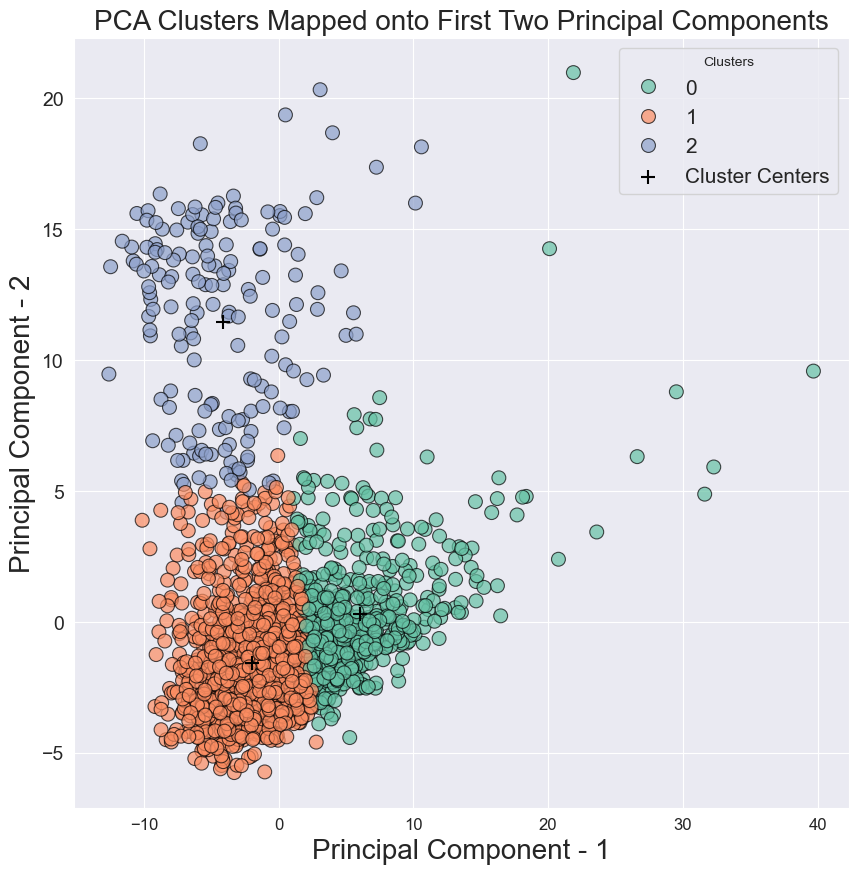

In [33]:
# Store the cluster labels
pcalabels = kmeanspca.labels_
pcacenters = kmeanspca.cluster_centers_

# Add pcalabels to the merged_df DataFrame for hue mapping
merged_df['pcalabels'] = pcalabels

# figure settings
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1', fontsize=20)
plt.ylabel('Principal Component - 2', fontsize=20)
plt.title("PCA Clusters Mapped onto First Two Principal Components", fontsize=20)

# Plot the scatterplot with K-means clusters as hue
sns.scatterplot(data=merged_df, 
                x='principal component 1', 
                y='principal component 2', 
                hue='pcalabels',  # Using the labels from the merged_df
                palette='Set2',  # Color palette
                s=100,  # Size of the points
                edgecolor='black',  # Black edges for better visibility
                alpha=0.7)  # Slight transparency

# Plot the cluster centers 
plt.scatter(pcacenters[:, 0], pcacenters[:, 1], s=100, c='black', marker='+', label='Cluster Centers')

# Show the legend
plt.legend(title="Clusters", prop={'size': 15})

# Show the plot
plt.show()

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [34]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# Sklearn libraries
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

# Keras libraries
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [35]:
# Convert HSD010_binary back to numeric, mapping 'good' to 0 and 'poor' to 1
NNnhanes_target=nhanestarget
NNnhanes_target['HSD010_binary'] = NNnhanes_target['HSD010_binary'].map({'good': 0, 'poor': 1})
X=NNnhanes_target.drop(['HSD010', 'HSD010_binary'], axis = 1) # drop out any columns that aren't features

In [36]:
NNnhanes_target.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010,HSD010_binary
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,excellent,0
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,excellent,0
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,very good,0
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,very good,0
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,good,0


In [37]:
# partition data
# -----------
y = NNnhanes_target['HSD010_binary'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = X 

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [38]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
num_classes = y_test.shape[1]

In [39]:
print(y_train[0]) 

[1. 0.]


In [40]:
# create neural network model
# -----------
model = Sequential()

num_pixels = X_train.shape[1] 

#input layer
model.add(Dense(num_pixels, input_dim= num_pixels, kernel_initializer= 'normal', activation= 'relu'))

#output layer
model.add(Dense(num_classes, kernel_initializer= 'normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

#fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)


Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 146ms/step - accuracy: 0.8359 - loss: 0.4512 - val_accuracy: 0.8566 - val_loss: 0.3849
Epoch 2/10
8/8 - 0s - 14ms/step - accuracy: 0.8598 - loss: 0.3398 - val_accuracy: 0.8643 - val_loss: 0.3607
Epoch 3/10
8/8 - 0s - 14ms/step - accuracy: 0.8786 - loss: 0.2984 - val_accuracy: 0.8663 - val_loss: 0.3533
Epoch 4/10
8/8 - 0s - 15ms/step - accuracy: 0.8941 - loss: 0.2642 - val_accuracy: 0.8682 - val_loss: 0.3492
Epoch 5/10
8/8 - 0s - 15ms/step - accuracy: 0.9037 - loss: 0.2358 - val_accuracy: 0.8702 - val_loss: 0.3473
Epoch 6/10
8/8 - 0s - 15ms/step - accuracy: 0.9186 - loss: 0.2131 - val_accuracy: 0.8682 - val_loss: 0.3476
Epoch 7/10
8/8 - 0s - 15ms/step - accuracy: 0.9302 - loss: 0.1874 - val_accuracy: 0.8663 - val_loss: 0.3530
Epoch 8/10
8/8 - 0s - 14ms/step - accuracy: 0.9412 - loss: 0.1663 - val_accuracy: 0.8682 - val_loss: 0.3571
Epoch 9/10
8/8 - 0s - 14ms/step - accuracy: 0.9470 - loss: 0.1478 - val_accuracy: 0.8663 - val_loss: 0.3657
Epoch 10/10
8/8 - 0s - 14ms/step - acc

### Neural Network on Principal Components

In [41]:
# Convert the PCA result to a DataFrame 
pca5_df = pd.DataFrame(data = pca5_result, 
                      columns = ['principal component 1', 
                                 'principal component 2',
                                'principal component 3',
                                'principal component 4',
                                'principal component 5'])

In [42]:
# partition data
# -----------
y = NNnhanes_target['HSD010_binary'] 
X = pca5_df # using our 5 component PCA as the features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [43]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
num_classes = y_test.shape[1]

In [44]:
# create neural network model
# -----------
model = Sequential()

num_pixels = X_train.shape[1] 

#input layer
model.add(Dense(num_pixels, input_dim= num_pixels, kernel_initializer= 'normal', activation= 'relu'))

#output layer
model.add(Dense(num_classes, kernel_initializer= 'normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

#fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)


Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 132ms/step - accuracy: 0.7242 - loss: 0.6887 - val_accuracy: 0.8391 - val_loss: 0.6813
Epoch 2/10
8/8 - 0s - 13ms/step - accuracy: 0.8307 - loss: 0.6768 - val_accuracy: 0.8488 - val_loss: 0.6694
Epoch 3/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6647 - val_accuracy: 0.8488 - val_loss: 0.6572
Epoch 4/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6523 - val_accuracy: 0.8488 - val_loss: 0.6439
Epoch 5/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6385 - val_accuracy: 0.8488 - val_loss: 0.6297
Epoch 6/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6237 - val_accuracy: 0.8488 - val_loss: 0.6142
Epoch 7/10
8/8 - 0s - 17ms/step - accuracy: 0.8359 - loss: 0.6073 - val_accuracy: 0.8488 - val_loss: 0.5978
Epoch 8/10
8/8 - 0s - 12ms/step - accuracy: 0.8359 - loss: 0.5904 - val_accuracy: 0.8488 - val_loss: 0.5806
Epoch 9/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.5727 - val_accuracy: 0.8488 - val_loss: 0.5633
Epoch 10/10
8/8 - 0s - 13ms/step - acc

### Neural Network on Principal Components + Cluster Membership (Original Data)

In [45]:
# Add cluster labels (from cluster algorithm trained on the ORIGINAL data) to the PCA DataFrame (as an additional feature)
kmeans_labels = kmeans.labels_
pca5_df['cluster_label'] = kmeans_labels
print(pca5_df.head())

   principal component 1  principal component 2  principal component 3  \
0               9.527811              -0.816224              -1.867097   
1              -5.838339              -3.692572               3.805800   
2              -0.719454              -2.573200               0.907954   
3               3.533627              -2.576983              -3.249186   
4              -6.872094              -4.194240               0.886837   

   principal component 4  principal component 5  cluster_label  
0              -2.109635              -3.930159              1  
1              -1.028763               0.392438              0  
2              -4.754922              -1.795701              0  
3              -0.406051               3.992514              1  
4              -0.848700              -0.521561              0  


In [46]:
# partition data
# -----------
y = NNnhanes_target['HSD010_binary'] 
X = pca5_df # using our 5 component PCA and cluster membership as the features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [47]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
num_classes = y_test.shape[1]

In [48]:
# create neural network model
# -----------
model = Sequential()

num_pixels = X_train.shape[1] 

#input layer
model.add(Dense(num_pixels, input_dim= num_pixels, kernel_initializer= 'normal', activation= 'relu'))

#output layer
model.add(Dense(num_classes, kernel_initializer= 'normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

#fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 135ms/step - accuracy: 0.6512 - loss: 0.6868 - val_accuracy: 0.7984 - val_loss: 0.6780
Epoch 2/10
8/8 - 0s - 13ms/step - accuracy: 0.8230 - loss: 0.6746 - val_accuracy: 0.8488 - val_loss: 0.6654
Epoch 3/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6619 - val_accuracy: 0.8488 - val_loss: 0.6525
Epoch 4/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6487 - val_accuracy: 0.8488 - val_loss: 0.6386
Epoch 5/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6345 - val_accuracy: 0.8488 - val_loss: 0.6234
Epoch 6/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6188 - val_accuracy: 0.8488 - val_loss: 0.6071
Epoch 7/10
8/8 - 0s - 12ms/step - accuracy: 0.8359 - loss: 0.6018 - val_accuracy: 0.8488 - val_loss: 0.5896
Epoch 8/10
8/8 - 0s - 12ms/step - accuracy: 0.8359 - loss: 0.5840 - val_accuracy: 0.8488 - val_loss: 0.5710
Epoch 9/10
8/8 - 0s - 12ms/step - accuracy: 0.8359 - loss: 0.5650 - val_accuracy: 0.8488 - val_loss: 0.5521
Epoch 10/10
8/8 - 0s - 12ms/step - acc

### Neural Network on Principal Components + Cluster Membership (Trained on PCA Results)

In [49]:
# Add cluster labels to the PCA DataFrame (as an additional feature)
pca5_df['cluster_label'] = pcalabels
print(pca5_df.head())

   principal component 1  principal component 2  principal component 3  \
0               9.527811              -0.816224              -1.867097   
1              -5.838339              -3.692572               3.805800   
2              -0.719454              -2.573200               0.907954   
3               3.533627              -2.576983              -3.249186   
4              -6.872094              -4.194240               0.886837   

   principal component 4  principal component 5  cluster_label  
0              -2.109635              -3.930159              0  
1              -1.028763               0.392438              1  
2              -4.754922              -1.795701              1  
3              -0.406051               3.992514              0  
4              -0.848700              -0.521561              1  


In [50]:
# partition data
# -----------
y = NNnhanes_target['HSD010_binary'] 
X = pca5_df # using our 5 component PCA and cluster membership as the features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [51]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
num_classes = y_test.shape[1]

In [52]:
# create neural network model
# -----------
model = Sequential()

num_pixels = X_train.shape[1] 

#input layer
model.add(Dense(num_pixels, input_dim= num_pixels, kernel_initializer= 'normal', activation= 'relu'))

#output layer
model.add(Dense(num_classes, kernel_initializer= 'normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

#fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)


Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 130ms/step - accuracy: 0.5342 - loss: 0.6936 - val_accuracy: 0.7171 - val_loss: 0.6847
Epoch 2/10
8/8 - 0s - 13ms/step - accuracy: 0.7881 - loss: 0.6830 - val_accuracy: 0.8469 - val_loss: 0.6741
Epoch 3/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6729 - val_accuracy: 0.8488 - val_loss: 0.6636
Epoch 4/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6624 - val_accuracy: 0.8488 - val_loss: 0.6526
Epoch 5/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6512 - val_accuracy: 0.8488 - val_loss: 0.6401
Epoch 6/10
8/8 - 0s - 12ms/step - accuracy: 0.8359 - loss: 0.6383 - val_accuracy: 0.8488 - val_loss: 0.6261
Epoch 7/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6236 - val_accuracy: 0.8488 - val_loss: 0.6104
Epoch 8/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.6072 - val_accuracy: 0.8488 - val_loss: 0.5931
Epoch 9/10
8/8 - 0s - 13ms/step - accuracy: 0.8359 - loss: 0.5891 - val_accuracy: 0.8488 - val_loss: 0.5742
Epoch 10/10
8/8 - 0s - 14ms/step - acc

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"